### **Part 1 – Problem Definition & Data Collection**

#### **1.1 Problem Definition**

The goal of this project is to build a machine learning model that predicts whether a chemical compound is **active or inactive toward the Androgen Receptor (NR-AR)** based solely on its molecular structure.

##### **Why is this important?**
NR-AR activity is a key nuclear receptor–mediated toxicity endpoint associated with endocrine disruption and hormone-related adverse effects. Experimental testing for NR-AR activity is costly, time-consuming, and impractical to perform exhaustively across large chemical libraries.
Computational toxicity models enable early-stage screening and prioritization, allowing potentially hazardous compounds to be identified before experimental testing and supporting more efficient ADMET-driven decision making.
##### **Dataset**
This project uses the Tox21 benchmark dataset from MoleculeNet and focuses on a single-task classification setting for the NR-AR endpoint.

- **Input:** Molecular structures represented as SMILES strings  
- **Output:** Binary classification label  
  - `1` = NR-AR active (toxic)  
  - `0` = NR-AR inactive (non-toxic)  
- The dataset is **strongly imbalanced**, with active compounds representing approximately **4–5%** of the data.
- Molecular features (physicochemical descriptors and fingerprints) are generated using RDKit.
- Compounds with missing NR-AR labels or invalid SMILES are removed prior to feature generation.
- A **scaffold-aware Train/Test split** is constructed to ensure chemically realistic model evaluation.

##### **Objective**
The objective of this project is not only to perform binary classification, but to develop a toxicity prioritization model that can rank compounds by their likelihood of NR-AR activity. The model is designed to generalize to previously unseen chemical scaffolds, enabling effective screening under severe class imbalance. Model performance is evaluated using metrics appropriate for imbalanced toxicity prediction and prioritization tasks, including:

- ROC-AUC (overall discrimination)
- PR-AUC (primary metric for ranking toxic compounds)
- Precision and Recall for the mutagenic class
- F1-score
- Accuracy


#### **1.2 Data Collection**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset

from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Descriptors, Crippen, Lipinski, rdMolDescriptors, rdFingerprintGenerator
from rdkit.Chem.MolStandardize import rdMolStandardize

In [2]:
# Load dataset
df = pd.read_csv(r"C:\Users\nezih\tox21.csv")
df.head()

,NR-AR,NR-AR-LBD,NR-AhR,NR-Aromatase,NR-ER,NR-ER-LBD,NR-PPAR-gamma,SR-ARE,SR-ATAD5,SR-HSE,SR-MMP,SR-p53,mol_id,smiles
0,0.0,0.0,1.0,NaN,NaN,0.0,0.0,1.0,0.0,0.0,0.0,0.0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,TOX3024,CC[C@]1(O)CC[C@H]2[C@@H]3CCC4=CCCC[C@@H]4[C@H]...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,0.0,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O


### **Part 2 – Exploratory Data Analysis (EDA)**

#### **2.1 Dataset Overview**

In [3]:
# Check basic dataset info
print("Shape:", df.shape)
print("Columns:", df.columns)

Shape: (7831, 14)
Columns: Index(['NR-AR', 'NR-AR-LBD', 'NR-AhR', 'NR-Aromatase', 'NR-ER', 'NR-ER-LBD',
       'NR-PPAR-gamma', 'SR-ARE', 'SR-ATAD5', 'SR-HSE', 'SR-MMP', 'SR-p53',
       'mol_id', 'smiles'],
      dtype='object')


In [4]:
# Check datatypes
print(df.dtypes)

NR-AR            float64
NR-AR-LBD        float64
NR-AhR           float64
NR-Aromatase     float64
NR-ER            float64
NR-ER-LBD        float64
NR-PPAR-gamma    float64
SR-ARE           float64
SR-ATAD5         float64
SR-HSE           float64
SR-MMP           float64
SR-p53           float64
mol_id            object
smiles            object
dtype: object


In [5]:
# Check for missing values
print(df.isnull().sum())

NR-AR             566
NR-AR-LBD        1073
NR-AhR           1282
NR-Aromatase     2010
NR-ER            1638
NR-ER-LBD         876
NR-PPAR-gamma    1381
SR-ARE           1999
SR-ATAD5          759
SR-HSE           1364
SR-MMP           2021
SR-p53           1057
mol_id              0
smiles              0
dtype: int64


Due to the multi-assay nature of Tox21, many compounds lack measurements for specific endpoints. In this study, compounds without an observed NR-AR label were excluded, resulting in a clean single-task dataset suitable for QSAR modeling.

In [7]:
# Drop rows where the NR-AR label is missing (NaN)
df_nr_ar_labeled = df.dropna(subset=["NR-AR"]).copy()

# Optional sanity checks
print("Number of remaining samples:", df_nr_ar_labeled.shape[0])
print("Number of missing NR-AR labels after filtering:", df_nr_ar_labeled["NR-AR"].isna().sum())


Number of remaining samples: 7265
Number of missing NR-AR labels after filtering: 0


In [9]:
# Target distribution
print(df_nr_ar_labeled["NR-AR"].value_counts())
print(df_nr_ar_labeled["NR-AR"].value_counts(normalize=True).round(3))

NR-AR
0.0    6956
1.0     309
Name: count, dtype: int64
NR-AR
0.0    0.957
1.0    0.043
Name: proportion, dtype: float64


In [10]:
# Duplicate check
print("Unique SMILES:", df_nr_ar_labeled['smiles'].nunique())
print("Total rows:", len(df_nr_ar_labeled))
print("Duplicate SMILES:", len(df_nr_ar_labeled) - df_nr_ar_labeled['smiles'].nunique())

Unique SMILES: 7265
Total rows: 7265
Duplicate SMILES: 0


In [11]:
# Invalid SMILES check
from rdkit import Chem
invalid = df_nr_ar_labeled['smiles'].apply(lambda x: Chem.MolFromSmiles(x) is None).sum()
print("Invalid SMILES:", invalid)

[20:41:32] WARNING: not removing hydrogen atom without neighbors
[20:41:33] Explicit valence for atom # 3 Al, 6, is greater than permitted
[20:41:33] Explicit valence for atom # 4 Al, 6, is greater than permitted
[20:41:33] Explicit valence for atom # 4 Al, 6, is greater than permitted
[20:41:33] Explicit valence for atom # 9 Al, 6, is greater than permitted
[20:41:33] Explicit valence for atom # 5 Al, 6, is greater than permitted
[20:41:33] Explicit valence for atom # 16 Al, 6, is greater than permitted


Invalid SMILES: 7


[20:41:33] Explicit valence for atom # 20 Al, 6, is greater than permitted


In [12]:
# Delete invalid SMILES
from rdkit import RDLogger

# Disable RDKit error logs
RDLogger.DisableLog("rdApp.error")

def is_valid_smiles(smiles):
    """Return True if RDKit can parse the SMILES string."""
    return Chem.MolFromSmiles(smiles) is not None

# Create a clean modeling dataset by removing invalid SMILES
df_model = df_nr_ar_labeled[df_nr_ar_labeled["smiles"].apply(is_valid_smiles)].copy()
df_model = df_model.reset_index(drop=True)

print("Original df_nr_ar_labeled shape:", df_nr_ar_labeled.shape)
print("df_model shape after removing invalid SMILES:", df_model.shape)


[21:25:58] WARNING: not removing hydrogen atom without neighbors


Original df_nr_ar_labeled shape: (7265, 14)
df_model shape after removing invalid SMILES: (7258, 14)


All molecular structures were validated using RDKit. Eight SMILES strings failed chemical valence checks and were removed, resulting in a cleaned dataset of 7,258 unique and chemically valid molecules for subsequent modeling.

In [13]:
#Class distribution (NR-AR)
df_model["NR-AR"].value_counts()

NR-AR
0.0    6950
1.0     308
Name: count, dtype: int64

After filtering for observed NR-AR labels and removing invalid SMILES, the final dataset contains 7,258 compounds, with 308 actives (4.24%) and 6,950 inactives (95.76%), indicating strong class imbalance typical of Tox21 assays.

#### Chemical Standardization Strategy

Although comprehensive chemical standardization pipelines (e.g., salt/fragment removal, charge neutralization, tautomer canonicalization, stereochemistry normalization) are commonly applied when working with heterogeneous raw sources, they are not strictly required for the Tox21 benchmark setting used in this project. Tox21 is a widely used toxicity benchmark distributed with SMILES strings that are generally consistent for QSAR modeling; therefore, we prioritized a minimal preprocessing strategy to preserve chemically meaningful structure–toxicity signals. As a quality-control step, all SMILES were validated for RDKit parsability and chemically invalid structures (e.g., valence violations) were removed (8 entries). In addition, since Tox21 is a multi-assay dataset with substantial missing labels, we restricted modeling to compounds with an observed NR-AR label to avoid label-imputation bias in a single-task setting. Given this benchmark context, aggressive normalization steps such as uncharging or tautomer canonicalization were intentionally avoided to prevent unnecessary alterations that could obscure relevant structure–activity relationships. Therefore, chemical preprocessing in this project was limited to RDKit-based SMILES validation and canonical SMILES generation, balancing data cleanliness with preservation of chemically relevant information.

#### **2.2 Visualization of Sample Molecules with Class Labels (RDKit)**

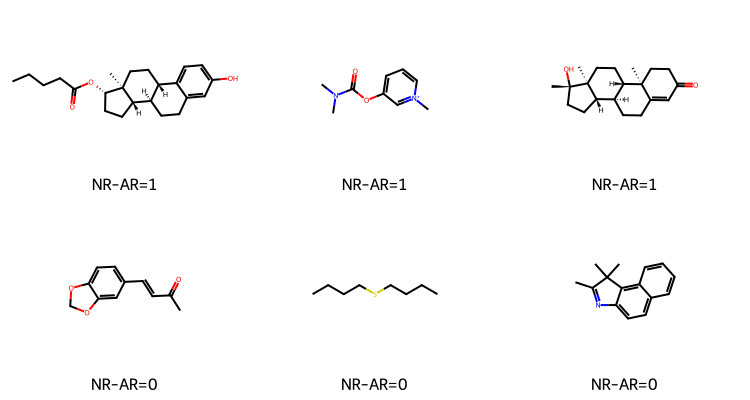

In [14]:
# Visualize a small random sample of molecules with class labels (RDKit)

from rdkit.Chem.Draw import MolsToGridImage

# Choose which SMILES column to use (prefer canonical if available)
smiles_col = "smiles"

# Pick a small, balanced random sample (NR-AR: 1 = active, 0 = inactive)
pos = df_model[df_model["NR-AR"] == 1].sample(n=3, random_state=42)
neg = df_model[df_model["NR-AR"] == 0].sample(n=3, random_state=42)
sample_df = pd.concat([pos, neg], ignore_index=True)

# Convert SMILES -> RDKit Mol objects
mols, legends = [], []
for _, row in sample_df.iterrows():
    mol = Chem.MolFromSmiles(row[smiles_col])
    if mol is None:
        continue
    mols.append(mol)
    legends.append(f"NR-AR={int(row['NR-AR'])}")

# Draw a grid image
img = MolsToGridImage(
    mols,
    molsPerRow=3,
    subImgSize=(250, 200),
    legends=legends
)

img

#### **2.3 Single-Task Dataset Construction (NR-AR)**

In [16]:
# Create a clean single-task table for NR-AR before feature generation

smiles_col = "smiles"

# Keep only the columns needed for modeling
keep_cols = [c for c in ["mol_id", smiles_col, "NR-AR"] if c in df_model.columns]
df_nr_ar = df_model[keep_cols].copy()

# Standardize column names for downstream consistency
df_nr_ar = df_nr_ar.rename(columns={smiles_col: "smiles", "NR-AR": "Activity"})

# Ensure the label is integer (0/1)
df_nr_ar["Activity"] = df_nr_ar["Activity"].astype(int)

# Sanity checks
print("df_nr_ar shape:", df_nr_ar.shape)
print("Missing Activity labels:", df_nr_ar["Activity"].isna().sum())
print("Class distribution:\n", df_nr_ar["Activity"].value_counts())


df_nr_ar shape: (7258, 3)
Missing Activity labels: 0
Class distribution:
 Activity
0    6950
1     308
Name: count, dtype: int64


#### **2.3 Calculation of Lipinski's Drug-Likeness Descriptors**

In [17]:
# Function: compute Lipinski descriptors for a molecule

# Create RDKit Mol objects
df_nr_ar["mol"] = df_nr_ar["smiles"].apply(Chem.MolFromSmiles)

def compute_lipinski_descriptors(mol):
    if mol is None:
        return pd.Series({
            "MolWt": None,
            "MolLogP": None,
            "HBD": None,
            "HBA": None,
            "TPSA": None,
            "RotatableBonds": None
        })
    return pd.Series({
        "MolWt": Descriptors.MolWt(mol),                       # Molecular weight
        "MolLogP": Crippen.MolLogP(mol),                       # LogP
        "HBD": Lipinski.NumHDonors(mol),                       # H-bond donors
        "HBA": Lipinski.NumHAcceptors(mol),                    # H-bond acceptors
        "TPSA": rdMolDescriptors.CalcTPSA(mol),                # Polar surface area
        "RotatableBonds": rdMolDescriptors.CalcNumRotatableBonds(mol)  # Rotatable bonds
    })

# Compute descriptors
df_lipinski = df_nr_ar["mol"].apply(compute_lipinski_descriptors)

# Quick check
print(df_lipinski.head())

[21:34:59] WARNING: not removing hydrogen atom without neighbors


     MolWt  MolLogP  HBD  HBA    TPSA  RotatableBonds
0  258.324  1.34240  1.0  5.0   82.28             3.0
1  204.229  1.29940  1.0  2.0   49.41             2.0
2  276.424  3.75244  1.0  2.0   32.34             7.0
3  206.027 -0.99220  5.0  3.0  135.29             2.0
4  290.444  4.81720  0.0  4.0   36.92             7.0


#### **2.4 Combine Molecule Dataset and Lipinski Features**

In [18]:
# Check if both DataFrames have exactly the same index
if df_nr_ar.index.equals(df_lipinski.index):
    print("✅ Index match perfectly – safe to concat without reset_index.")
else:
    print("⚠️ Index do NOT match – better use reset_index(drop=True).")

# Combine original molecule data with Lipinski descriptors
df_combined = pd.concat([df_nr_ar, df_lipinski], axis=1)

df_combined.head()

✅ Index match perfectly – safe to concat without reset_index.


,mol_id,smiles,Activity,mol,MolWt,MolLogP,HBD,HBA,TPSA,RotatableBonds
0,TOX3021,CCOc1ccc2nc(S(N)(=O)=O)sc2c1,0,<rdkit.Chem.rdchem.Mol object at 0x00000210845...,258.324,1.34240,1.0,5.0,82.28,3.0
1,TOX3020,CCN1C(=O)NC(c2ccccc2)C1=O,0,<rdkit.Chem.rdchem.Mol object at 0x00000210845...,204.229,1.29940,1.0,2.0,49.41,2.0
2,TOX3027,CCCN(CC)C(CC)C(=O)Nc1c(C)cccc1C,0,<rdkit.Chem.rdchem.Mol object at 0x00000210845...,276.424,3.75244,1.0,2.0,32.34,7.0
3,TOX20800,CC(O)(P(=O)(O)O)P(=O)(O)O,0,<rdkit.Chem.rdchem.Mol object at 0x00000210845...,206.027,-0.99220,5.0,3.0,135.29,2.0
4,TOX5110,CC(C)(C)OOC(C)(C)CCC(C)(C)OOC(C)(C)C,0,<rdkit.Chem.rdchem.Mol object at 0x00000210845...,290.444,4.81720,0.0,4.0,36.92,7.0


#### **2.5 Descriptor Quality Control**

In [19]:
# Descriptor quality check (Lipinski)
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

print("Missing values per descriptor:")
print(df_combined[desc_cols].isna().sum())

print("\nInfinite values per descriptor:")
print(np.isinf(df_combined[desc_cols].to_numpy(dtype=float)).sum(axis=0))

summary = df_combined[desc_cols].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T
summary = summary[["count", "mean", "std", "min", "1%", "5%", "50%", "95%", "99%", "max"]]
print("\nDescriptor summary statistics:")
print(summary)

group_stats = df_combined.groupby("Activity")[desc_cols].agg(["mean", "median"])
print("\nClass-wise descriptor stats (mean/median):")
print(group_stats)

Missing values per descriptor:
MolWt             0
MolLogP           0
HBD               0
HBA               0
TPSA              0
RotatableBonds    0
dtype: int64

Infinite values per descriptor:
[0 0 0 0 0 0]

Descriptor summary statistics:
                 count        mean         std      min         1%         5%  \
MolWt           7258.0  274.348524  164.555365   9.0120  73.095000  102.13300   
MolLogP         7258.0    2.392206    2.312094 -17.4064  -3.744482   -1.03851   
HBD             7258.0    1.202535    1.916770   0.0000   0.000000    0.00000   
HBA             7258.0    3.511160    3.162138   0.0000   0.000000    0.00000   
TPSA            7258.0   58.681657   57.946209   0.0000   0.000000    0.00000   
RotatableBonds  7258.0    4.298154    4.504599   0.0000   0.000000    0.00000   

                     50%         95%         99%        max  
MolWt           238.2445  555.879050  873.956880  1877.6640  
MolLogP           2.3749    5.983977    8.339937    22.6118  
HBD

All Lipinski descriptors were successfully computed without missing or infinite values. The observed ranges and summary statistics are consistent with the chemical diversity of the Tox21 NR-AR dataset, with moderate differences between active and inactive compounds, indicating the presence of learnable structure–activity signal. No additional filtering or transformation was applied at this stage, as descriptor scaling is handled downstream.

#### **2.6 Correlation Heatmap of Molecular Descriptors**

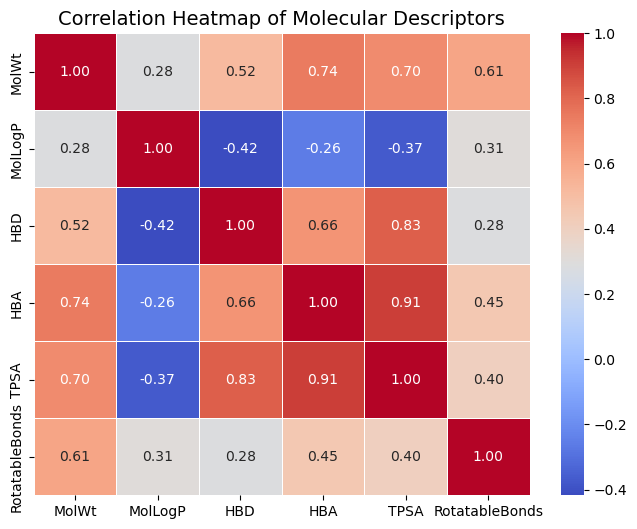

In [20]:
# Descriptor columns to include in correlation
desc_cols = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# Compute correlation matrix
corr_matrix = df_combined[desc_cols].corr(method="pearson")

# Plot heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap of Molecular Descriptors", fontsize=14)
plt.show()

#### Interpretation of Descriptor Correlations

Several Lipinski descriptors exhibit moderate to strong correlations (e.g., TPSA–HBA, TPSA–HBD, MolWt–HBA), reflecting known physicochemical relationships. This level of collinearity is expected for basic molecular descriptors and is handled downstream via feature scaling and the use of regularized (Logistic Regression) and tree-based (Random Forest) models. No descriptor removal was performed to preserve interpretability and consistency with the Ames pipeline.


### **Part 3 – Feature Engineering / Descriptor Calculation**

#### **3.1 Morgan Fingerprints (ECFP4)**

In [22]:
#  Morgan fingerprint (ECFP4, radius=2, 2048 bits) for Ames dataset

gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=2048)

def morgan_fp_bits(smiles: str) -> np.ndarray:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(2048, dtype=np.uint8)
    fp = gen.GetFingerprint(mol)
    arr = np.zeros(2048, dtype=np.uint8)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr
    
X_fp = np.vstack(df_combined["smiles"].apply(morgan_fp_bits).values)

print("X_fp shape:", X_fp.shape)  


[22:35:50] WARNING: not removing hydrogen atom without neighbors


X_fp shape: (7258, 2048)


In [24]:
# Convert to DataFrame
fp_columns = [f"FP_{i}" for i in range(X_fp.shape[1])]
fp_df = pd.DataFrame(X_fp, columns=fp_columns, index=df_combined.index)

fp_df.head()


,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_2038,FP_2039,FP_2040,FP_2041,FP_2042,FP_2043,FP_2044,FP_2045,FP_2046,FP_2047
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### **3.2 Preparing Final Descriptor Set for Modeling**

In [25]:
# 1) Define candidate descriptor columns (Lipinski-like block)
desc_all = ["MolWt", "MolLogP", "HBD", "HBA", "TPSA", "RotatableBonds"]

# 2) Choose the dataframe that contains descriptors + labels
# If you already merged descriptors into df_nr_ar, use df_nr_ar. Otherwise use df_combined.
df_feat = df_nr_ar if all(c in df_nr_ar.columns for c in desc_all) else df_combined

# 3) Keep only those that actually exist
desc_cols = [c for c in desc_all if c in df_feat.columns]
print("Using descriptor columns:", desc_cols)

# 4) Sanity check: at least one descriptor must be present
assert len(desc_cols) > 0, "No descriptor columns found in df_feat!"

# 5) Build descriptor matrix X_desc and labels y (Tox21 label column is 'Activity')
X_desc = df_feat[desc_cols].astype(float).to_numpy()
y = df_feat["Activity"].astype(int).to_numpy()

# 6) Hybrid feature matrix: descriptors + fingerprints
# Note: X_fp must have the same row order as df_feat
assert X_desc.shape[0] == X_fp.shape[0], "Row count mismatch between X_desc and X_fp!"

X_hybrid = np.hstack([X_desc, X_fp])

print("X_desc:", X_desc.shape)
print("X_fp:", X_fp.shape)
print("X_hybrid:", X_hybrid.shape)
print("y:", y.shape)


Using descriptor columns: ['MolWt', 'MolLogP', 'HBD', 'HBA', 'TPSA', 'RotatableBonds']
X_desc: (7258, 6)
X_fp: (7258, 2048)
X_hybrid: (7258, 2054)
y: (7258,)


#### **3.3 Train-Test Split**

**Murcko scaffold** represents the core ring systems and linkers of a molecule after removing peripheral substituents. **Scaffold-based splitting** groups molecules by their shared chemical backbone and assigns entire scaffolds exclusively to either the training or test set. This strategy prevents structural information **leakage** caused by closely related compounds appearing in both sets and provides a more realistic evaluation of model generalization, which is particularly important in QSAR and ADMET modeling.

In [30]:
# Scaffold-based Train / Test split (Murcko)

from rdkit.Chem.Scaffolds import MurckoScaffold

def murcko_scaffold(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)

# 1) Compute scaffolds from canonical SMILES
scaff = df_combined["smiles"].apply(murcko_scaffold)

# 2) Drop rows with invalid scaffolds (rare, but safe)
valid_mask = scaff.notna().to_numpy()
dfv = df_combined.loc[valid_mask].copy()

Xv = X_hybrid[valid_mask]
yv = dfv["Activity"].astype(int).to_numpy()
scaff_v = scaff.loc[valid_mask].to_numpy()

# 3) Group indices by scaffold (indices are positions within dfv/Xv)
scaf_to_idx = {}
for i, s in enumerate(scaff_v):
    scaf_to_idx.setdefault(s, []).append(i)

# 4) Sort scaffold groups (largest first) for a deterministic split
groups = list(scaf_to_idx.values())
groups = sorted(groups, key=lambda g: (-len(g), g[0]))  # size desc, then stable

# 5) Allocate groups to Test, then Train (scaffold-level)
test_frac = 0.20
n_total = len(yv)
n_test_target = int(np.floor(test_frac * n_total))

test_idx, train_idx = [], []

for g in groups:
    if len(test_idx) + len(g) <= n_test_target:
        test_idx.extend(g)
    else:
        train_idx.extend(g)

# 6) Build final splits
X_train, y_train = Xv[train_idx], yv[train_idx]
X_test,  y_test  = Xv[test_idx],  yv[test_idx]

print("Scaffold split sizes:")
print("Train:", X_train.shape, y_train.shape)
print("Test: ", X_test.shape,  y_test.shape)

# 7) Verify no scaffold leakage
train_scaf = set(scaff_v[train_idx])
test_scaf  = set(scaff_v[test_idx])

print("\nScaffold overlap checks (should be 0):")
print("Train ∩ Test:", len(train_scaf & test_scaf))

# 8) Keep the corresponding rows as DataFrames
df_train = dfv.iloc[train_idx].copy()
df_test  = dfv.iloc[test_idx].copy()


[23:19:02] WARNING: not removing hydrogen atom without neighbors


Scaffold split sizes:
Train: (5807, 2054) (5807,)
Test:  (1451, 2054) (1451,)

Scaffold overlap checks (should be 0):
Train ∩ Test: 0


#### **Compare class distribution (Activity) in Train vs Test** 

In [31]:
# Compare class distribution (Activity) in Train vs Test

def class_distribution(series):
    counts = series.value_counts().sort_index()
    props = series.value_counts(normalize=True).sort_index()
    out = pd.DataFrame({"count": counts, "proportion": props.round(3)})
    return out

print("Train Activity distribution:")
print(class_distribution(df_train["Activity"]))

print("\nTest Activity distribution:")
print(class_distribution(df_test["Activity"]))

Train Activity distribution:
          count  proportion
Activity                   
0          5524       0.951
1           283       0.049

Test Activity distribution:
          count  proportion
Activity                   
0          1426       0.983
1            25       0.017


The Murcko scaffold split yields zero scaffold overlap between train and test sets, ensuring a leakage-free evaluation; however, due to scaffold grouping, the test set contains relatively few positives (n=25), which can increase variance in PR-AUC estimates and may motivate re-splitting with a different scaffold allocation seed or a slightly larger test fraction.

In [32]:
import numpy as np
from rdkit import Chem
from rdkit.Chem.Scaffolds import MurckoScaffold

# Base dataframe MUST match X_hybrid row order
df_base = df_nr_ar

def murcko_scaffold(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)

# 1) Compute scaffolds once
scaff = df_base["smiles"].apply(murcko_scaffold)
valid_mask = scaff.notna().to_numpy()

dfv = df_base.loc[valid_mask].copy()
Xv  = X_hybrid[valid_mask]
yv  = dfv["Activity"].astype(int).to_numpy()
scaff_v = scaff.loc[valid_mask].to_numpy()

# 2) Group indices by scaffold
scaf_to_idx = {}
for i, s in enumerate(scaff_v):
    scaf_to_idx.setdefault(s, []).append(i)
groups = list(scaf_to_idx.values())

def make_scaffold_split(groups, y, test_frac=0.20, seed=0):
    rng = np.random.RandomState(seed)
    gs = groups.copy()
    rng.shuffle(gs)

    n_total = len(y)
    n_test_target = int(np.floor(test_frac * n_total))

    test_idx, train_idx = [], []
    for g in gs:
        if len(test_idx) + len(g) <= n_test_target:
            test_idx.extend(g)
        else:
            train_idx.extend(g)

    return np.array(train_idx), np.array(test_idx)

# 3) Search for a split with enough positives in test
test_frac = 0.20
min_test_pos = 50     # hedef (istersen 40/60 yap)
max_tries = 300

best = None
for seed in range(max_tries):
    tr, te = make_scaffold_split(groups, yv, test_frac=test_frac, seed=seed)
    npos = int(yv[te].sum())
    if best is None or npos > best["npos"]:
        best = {"seed": seed, "train": tr, "test": te, "npos": npos}
    if npos >= min_test_pos:
        print(f"✅ Found split | seed={seed} | test positives={npos} | test size={len(te)}")
        break

if best["npos"] < min_test_pos:
    print(f"⚠️ Target not reached. Best: seed={best['seed']} with {best['npos']} positives.")
    print("Suggestion: increase test_frac to 0.25–0.30 and retry.")

# 4) Final split
train_idx, test_idx = best["train"], best["test"]
X_train, y_train = Xv[train_idx], yv[train_idx]
X_test,  y_test  = Xv[test_idx],  yv[test_idx]

# 5) Checks
train_scaf = set(scaff_v[train_idx])
test_scaf  = set(scaff_v[test_idx])
print("Leakage (Train ∩ Test scaffolds):", len(train_scaf & test_scaf))

def dist(y):
    vals, cnts = np.unique(y, return_counts=True)
    props = cnts / cnts.sum()
    return dict(zip(vals, zip(cnts, props.round(3))))

print("Train dist:", dist(y_train))
print("Test  dist:", dist(y_test))

# Optional aligned dataframes
df_train = dfv.iloc[train_idx].copy()
df_test  = dfv.iloc[test_idx].copy()


[20:16:22] WARNING: not removing hydrogen atom without neighbors


✅ Found split | seed=0 | test positives=108 | test size=1451
Leakage (Train ∩ Test scaffolds): 0
Train dist: {np.int64(0): (np.int64(5607), np.float64(0.966)), np.int64(1): (np.int64(200), np.float64(0.034))}
Test  dist: {np.int64(0): (np.int64(1343), np.float64(0.926)), np.int64(1): (np.int64(108), np.float64(0.074))}


**Scaffold-aware split refinement**.
The initial Murcko scaffold split produced a leakage-free test set but contained too few positive NR-AR actives, which can make PR-AUC estimates unstable. To obtain a more reliable evaluation while preserving scaffold exclusivity, we regenerated the scaffold split by shuffling scaffold groups with different random seeds and selecting a split that achieves a sufficient number of positives in the test set. The final split (seed=0) maintains zero scaffold overlap between train and test and increases test positives (n=108), improving the stability of downstream performance metrics without introducing structural leakage.

#### **3.4 Feature Scaling (Descriptor-Only Standardization)**

In [33]:
from sklearn.preprocessing import StandardScaler

# 1) Split X into descriptor block + fingerprint block
n_desc = 6  # MolWt, MolLogP, HBD, HBA, TPSA, RotatableBonds

X_desc_train = X_train[:, :n_desc]
X_fp_train   = X_train[:, n_desc:]

X_desc_test  = X_test[:, :n_desc]
X_fp_test    = X_test[:, n_desc:]

# 2) Fit scaler ONLY on train descriptors (prevents leakage)
scaler = StandardScaler()
X_desc_train_scaled = scaler.fit_transform(X_desc_train)
X_desc_test_scaled  = scaler.transform(X_desc_test)

# 3) Rebuild hybrid matrices (scaled descriptors + unscaled fingerprints)
X_train_scaled = np.hstack([X_desc_train_scaled, X_fp_train])
X_test_scaled  = np.hstack([X_desc_test_scaled,  X_fp_test])

print("X_train_scaled:", X_train_scaled.shape)
print("X_test_scaled: ", X_test_scaled.shape)



X_train_scaled: (5807, 2054)
X_test_scaled:  (1451, 2054)


Continuous molecular descriptors were standardized using a StandardScaler fitted  exclusively on the training set. The same transformation was applied to the test set. Binary Morgan fingerprints were left unscaled to preserve their original representation.


### **Part 4 – Model Building**

#### **4.1 Linear Baseline Model — Logistic Regression**

**Evaluation strategy:** Scaffold-aware cross-validation using GroupKFold with Murcko scaffolds

In [34]:
# Scaffold-aware cross-validation for Logistic Regression (GroupKFold)

from rdkit.Chem.Scaffolds import MurckoScaffold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score

# 1) Build scaffold groups for TRAIN set (one group id per molecule)
def murcko_scaffold(smiles: str):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    return MurckoScaffold.MurckoScaffoldSmiles(mol=mol, includeChirality=False)

scaff_train = df_train["smiles"].apply(murcko_scaffold)

# If any scaffold is None (rare), drop those rows consistently from X/y
valid_mask = scaff_train.notna().to_numpy()
X_tr = X_train_scaled[valid_mask]
y_tr = y_train[valid_mask]
groups_tr = scaff_train.loc[valid_mask].to_numpy()

print("Train rows (before):", len(df_train))
print("Train rows (used)  :", X_tr.shape[0])
print("Unique train scaffolds:", len(set(groups_tr)))

# 2) Define baseline logistic regression model
logreg = LogisticRegression(
    max_iter=2000,
    solver="lbfgs",
    class_weight="balanced"
)

# 3) Scaffold-aware CV (groups = scaffolds)
cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1":         make_scorer(f1_score, pos_label=1),
    "recall_pos": make_scorer(recall_score, pos_label=1),
    "roc_auc":    "roc_auc",
    "pr_auc":     "average_precision",
}

cv_results = cross_validate(
    logreg,
    X_tr,
    y_tr,
    cv=cv,
    groups=groups_tr,     # scaffold-aware
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

for metric in scoring.keys():
    scores = cv_results[f"test_{metric}"]
    print(f"{metric}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")


[15:50:40] WARNING: not removing hydrogen atom without neighbors


Train rows (before): 5807
Train rows (used)  : 5807
Unique train scaffolds: 1432
accuracy: 0.933 ± 0.035
f1: 0.200 ± 0.203
recall_pos: 0.236 ± 0.219
roc_auc: 0.632 ± 0.116
pr_auc: 0.197 ± 0.199


Under a scaffold-aware cross-validation setting, the Logistic Regression baseline achieves moderate ROC-AUC and a PR-AUC substantially above the random baseline. The model exhibits high precision but limited recall for the active class, which is a common and expected behavior in highly imbalanced toxicity classification tasks. These results establish a conservative but chemically meaningful baseline for subsequent non-linear models.


#### **4.2 Non-Linear Baseline Model — Random Forest**

**Evaluation strategy:** Scaffold-aware cross-validation using GroupKFold with Murcko scaffolds

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score

# Random Forest baseline (scaffold-aware CV) — Tox21 NR-AR
rf = RandomForestClassifier(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=1,
    class_weight="balanced",   # same style as your Ames baseline
    random_state=42,
    n_jobs=-1
)

cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1":         make_scorer(f1_score, pos_label=1),
    "recall_pos": make_scorer(recall_score, pos_label=1),
    "roc_auc":    "roc_auc",
    "pr_auc":     "average_precision",
}

cv_results_rf = cross_validate(
    rf,
    X_tr,          # train-only subset with valid scaffolds (same X_tr used in LR)
    y_tr,
    cv=cv,
    groups=groups_tr,  # scaffold-aware CV
    scoring=scoring,
    return_train_score=False,
    n_jobs=-1
)

for metric in scoring.keys():
    scores = cv_results_rf[f"test_{metric}"]
    print(f"{metric}: {np.mean(scores):.3f} ± {np.std(scores):.3f}")



accuracy: 0.967 ± 0.016
f1: 0.217 ± 0.195
recall_pos: 0.139 ± 0.131
roc_auc: 0.669 ± 0.114
pr_auc: 0.293 ± 0.258


Under scaffold-aware cross-validation, the Random Forest baseline substantially improves performance over Logistic Regression, particularly in PR-AUC, indicating a stronger ability to prioritize active NR-AR compounds under severe class imbalance. The model exhibits conservative recall, consistent with toxicity screening tasks.


### **Part 5 – Model Evaluation & Comparison**

#### **Model Performance Comparison (Scaffold-Aware Cross-Validation)**

| Metric        | Logistic Regression | Random Forest |
|--------------|---------------------|---------------|
| Accuracy     | 0.933 ± 0.035       | 0.967 ± 0.016 |
| F1-score     | 0.200 ± 0.203       | 0.217 ± 0.195 |
| Recall (pos) | 0.236 ± 0.219       | 0.139 ± 0.131 |
| ROC-AUC      | 0.632 ± 0.116       | 0.669 ± 0.114 |
| PR-AUC       | 0.197 ± 0.199       | 0.293 ± 0.258 |

Across all evaluation metrics, the Random Forest model improves overall discrimination compared to the Logistic Regression baseline under the same scaffold-aware cross-validation protocol. The most substantial gain is observed in PR-AUC, indicating a stronger ability to prioritize active NR-AR compounds under severe class imbalance. While Logistic Regression achieves higher recall for the active class, both models remain conservative, reflecting the intrinsic difficulty of toxicity prediction. Importantly, all improvements are obtained with zero scaffold overlap between training and test sets, ensuring a leakage-free and chemically realistic evaluation.



#### **5.1 Hyperparameter Tuning**

In [36]:
# Light hyperparameter tuning for Random Forest (scaffold-aware CV)
# Tuning only: n_estimators, max_depth, min_samples_leaf

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GroupKFold, ParameterGrid, cross_validate
from sklearn.metrics import make_scorer, accuracy_score, f1_score, recall_score
import numpy as np

# Reuse scaffold-aware CV setup from earlier
cv = GroupKFold(n_splits=5)

scoring = {
    "accuracy":   make_scorer(accuracy_score),
    "f1":         make_scorer(f1_score, pos_label=1),
    "recall_pos": make_scorer(recall_score, pos_label=1),
    "roc_auc":    "roc_auc",
    "pr_auc":     "average_precision",
}

# Small, practical grid (keep it light)
param_grid = {
    "n_estimators":      [300, 600],
    "max_depth":         [None, 20, 40],
    "min_samples_leaf":  [1, 2, 5],
}

results = []
for params in ParameterGrid(param_grid):
    rf = RandomForestClassifier(
        **params,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    cv_res = cross_validate(
        rf,
        X_tr,          # train-only (valid scaffolds)
        y_tr,
        cv=cv,
        groups=groups_tr,     # scaffold-aware
        scoring=scoring,
        return_train_score=False,
        n_jobs=-1
    )

    row = {"params": params}
    for m in scoring.keys():
        vals = cv_res[f"test_{m}"]
        row[f"{m}_mean"] = float(np.mean(vals))
        row[f"{m}_std"]  = float(np.std(vals))
    results.append(row)

# IMPORTANT FOR TOX21 NR-AR:
# Sort by PR-AUC mean (primary), then ROC-AUC mean (secondary)
results_sorted = sorted(
    results,
    key=lambda r: (r["pr_auc_mean"], r["roc_auc_mean"]),
    reverse=True
)

# Print top 10 configs
print("Top configs (sorted by PR-AUC, then ROC-AUC):\n")
for i, r in enumerate(results_sorted[:10], start=1):
    p = r["params"]
    print(
        f"{i:02d}) params={p} | "
        f"pr_auc={r['pr_auc_mean']:.3f}±{r['pr_auc_std']:.3f} | "
        f"roc_auc={r['roc_auc_mean']:.3f}±{r['roc_auc_std']:.3f} | "
        f"recall={r['recall_pos_mean']:.3f}±{r['recall_pos_std']:.3f} | "
        f"f1={r['f1_mean']:.3f}±{r['f1_std']:.3f} | "
        f"acc={r['accuracy_mean']:.3f}±{r['accuracy_std']:.3f}"
    )

# Best params dict (use this for final training)
best_params = results_sorted[0]["params"]
print("\nBest params:", best_params)



Top configs (sorted by PR-AUC, then ROC-AUC):

01) params={'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 600} | pr_auc=0.292±0.255 | roc_auc=0.685±0.101 | recall=0.147±0.145 | f1=0.224±0.208 | acc=0.968±0.016
02) params={'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 300} | pr_auc=0.292±0.257 | roc_auc=0.682±0.100 | recall=0.159±0.165 | f1=0.235±0.226 | acc=0.969±0.015
03) params={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 300} | pr_auc=0.292±0.259 | roc_auc=0.677±0.109 | recall=0.139±0.131 | f1=0.214±0.194 | acc=0.967±0.017
04) params={'max_depth': None, 'min_samples_leaf': 1, 'n_estimators': 600} | pr_auc=0.291±0.256 | roc_auc=0.672±0.110 | recall=0.131±0.118 | f1=0.205±0.180 | acc=0.966±0.017
05) params={'max_depth': 20, 'min_samples_leaf': 2, 'n_estimators': 300} | pr_auc=0.289±0.256 | roc_auc=0.657±0.138 | recall=0.239±0.224 | f1=0.314±0.280 | acc=0.972±0.013
06) params={'max_depth': 20, 'min_samples_leaf': 1, 'n_estimators': 600} | pr_auc=0.289±0

**Interpretation.**  
A light hyperparameter tuning was performed using scaffold-aware cross-validation, optimizing primarily for PR-AUC due to the severe class imbalance of the NR-AR endpoint. The selected Random Forest configuration (600 trees, max_depth=40, min_samples_leaf=1) achieved the highest PR-AUC while maintaining competitive ROC-AUC, indicating improved prioritization of active compounds without sacrificing overall discrimination.


#### **5.2 Final Evaluation on Test Set (Random Forest)**

In [38]:
# Final Random Forest training on full train set + evaluation on scaffold-held-out test set (Tox21 NR-AR)

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    recall_score,
    precision_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    classification_report,
)

# 1) Train final model (use best_params from your tuning)
# Best params you found:
# {'max_depth': 40, 'min_samples_leaf': 1, 'n_estimators': 600}

rf_final = RandomForestClassifier(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    min_samples_leaf=best_params["min_samples_leaf"],
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf_final.fit(X_train_scaled, y_train)

# 2) Predict on test set
y_pred = rf_final.predict(X_test_scaled)
y_proba = rf_final.predict_proba(X_test_scaled)[:, 1]

# 3) Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
rec = recall_score(y_test, y_pred, pos_label=1)
f1 = f1_score(y_test, y_pred, pos_label=1)
roc = roc_auc_score(y_test, y_proba)
pr  = average_precision_score(y_test, y_proba)

print("Final Test Set Performance (Random Forest):")
print(f"Accuracy : {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"Recall   : {rec:.3f}")
print(f"F1-score : {f1:.3f}")
print(f"ROC-AUC  : {roc:.3f}")
print(f"PR-AUC   : {pr:.3f}")

print("\nConfusion Matrix [ [TN, FP], [FN, TP] ]:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))



Final Test Set Performance (Random Forest):
Accuracy : 0.966
Precision: 0.968
Recall   : 0.556
F1-score : 0.706
ROC-AUC  : 0.850
PR-AUC   : 0.694

Confusion Matrix [ [TN, FP], [FN, TP] ]:
[[1341    2]
 [  48   60]]

Classification Report:
              precision    recall  f1-score   support

           0      0.965     0.999     0.982      1343
           1      0.968     0.556     0.706       108

    accuracy                          0.966      1451
   macro avg      0.967     0.777     0.844      1451
weighted avg      0.966     0.966     0.961      1451



**Final Test Set Evaluation.**  
The final Random Forest model, trained using tuned hyperparameters and evaluated on a scaffold-held-out test set, demonstrates strong generalization performance for the NR-AR endpoint. The model achieves a ROC-AUC of 0.85 and a PR-AUC of 0.69, substantially outperforming the random baseline under severe class imbalance. High precision (0.97) and moderate recall (0.56) indicate effective prioritization of active compounds with minimal false positives. All results were obtained under a leakage-free, scaffold-exclusive evaluation protocol, providing a chemically realistic estimate of performance.

#### **5.3 Model Performance Visualization (Test Set)**

#### **5.3.1 Confusion Matrix**

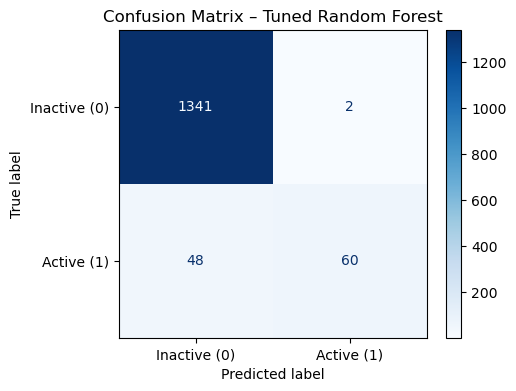

In [39]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Inactive (0)", "Active (1)"])
fig, ax = plt.subplots(figsize=(5, 4))
disp.plot(cmap="Blues", ax=ax, values_format='d')
plt.title("Confusion Matrix – Tuned Random Forest")
plt.savefig("confusion_matrix.png", dpi=300, bbox_inches="tight")
plt.show()


#### **5.3.2 Precision–Recall Curve**

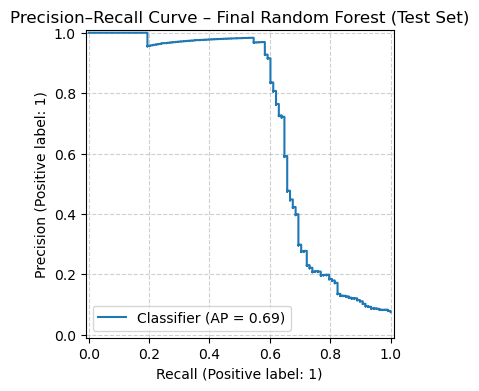

In [40]:
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 4))

pr_disp = PrecisionRecallDisplay.from_predictions(
    y_test,
    y_proba,   # <-- use your probability vector for class 1
    ax=ax
)

plt.title("Precision–Recall Curve – Final Random Forest (Test Set)")
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("precision_recall_curve.png", dpi=300, bbox_inches="tight")
plt.show()


**Precision–Recall Analysis.**  
The Precision–Recall curve demonstrates that the Random Forest model effectively prioritizes active NR-AR compounds, achieving very high precision at moderate recall levels. The Average Precision (AP) of 0.69, substantially exceeding the random baseline, highlights robust performance under severe class imbalance. This behavior indicates that the model is well suited for conservative toxicity screening scenarios, where minimizing false positives is critical.

#### **5.3.3 Top-N Enrichment Analysis (Hit-Rate & Enrichment Factor)**

Test set size: 1451
Total actives in test: 108 (0.074 positive rate)

Top-N enrichment summary:
Top  0% (N=   7): hits=  7 | hit_rate=1.000 | EF=13.44
Top  1% (N=  14): hits= 14 | hit_rate=1.000 | EF=13.44
Top  2% (N=  29): hits= 28 | hit_rate=0.966 | EF=12.97
Top  5% (N=  72): hits= 65 | hit_rate=0.903 | EF=12.13
Top 10% (N= 145): hits= 71 | hit_rate=0.490 | EF=6.58
Top 20% (N= 290): hits= 78 | hit_rate=0.269 | EF=3.61
Top 30% (N= 435): hits= 86 | hit_rate=0.198 | EF=2.66
Top 40% (N= 580): hits= 89 | hit_rate=0.153 | EF=2.06
Top 50% (N= 725): hits= 92 | hit_rate=0.127 | EF=1.70


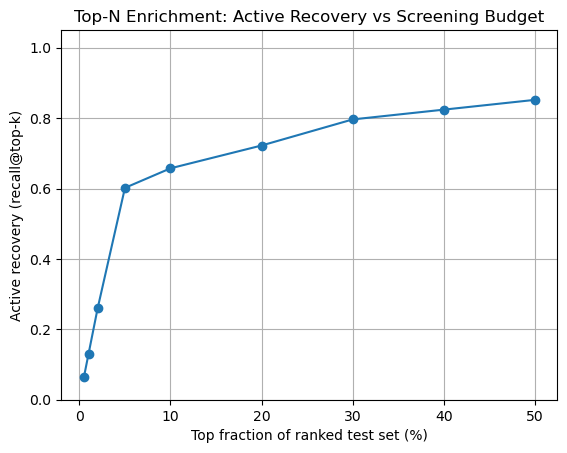

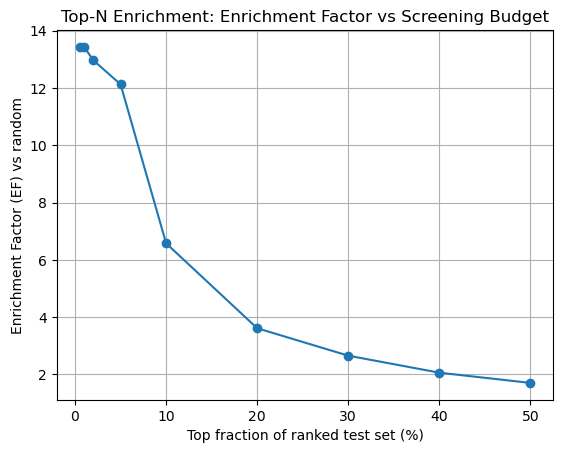

In [44]:
# Top-N enrichment / hit-rate plot on the test set
# Requires:
# - y_test  : array-like of shape (n_samples,), binary labels (0/1)
# - y_proba : array-like of shape (n_samples,), predicted probabilities for class 1

y_test_arr = np.asarray(y_test).astype(int)
y_proba_arr = np.asarray(y_proba).astype(float)

# Sort samples by predicted probability (descending)
order = np.argsort(-y_proba_arr)
y_sorted = y_test_arr[order]

n = len(y_sorted)
pos_total = int(y_sorted.sum())
pos_rate = pos_total / n if n > 0 else 0.0

# Fractions of the ranked list to evaluate (edit if you want fewer/more points)
fractions = np.array([0.005, 0.01, 0.02, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50])
fractions = fractions[(fractions > 0) & (fractions <= 1)]

topn = np.maximum(1, (fractions * n).astype(int))

hits = np.array([y_sorted[:k].sum() for k in topn], dtype=float)
hit_rate = hits / topn
ef = np.where(pos_rate > 0, hit_rate / pos_rate, np.nan)  # enrichment factor vs random

print(f"Test set size: {n}")
print(f"Total actives in test: {pos_total} ({pos_rate:.3f} positive rate)")
print("\nTop-N enrichment summary:")
for f, k, h, hr, e in zip(fractions, topn, hits.astype(int), hit_rate, ef):
    print(f"Top {int(f*100):2d}% (N={k:4d}): hits={h:3d} | hit_rate={hr:.3f} | EF={e:.2f}")

# Plot: cumulative actives captured vs top fraction
cum_hits = np.array([y_sorted[:k].sum() for k in topn], dtype=float)
max_hits = pos_total if pos_total > 0 else 1.0
recall_at_k = cum_hits / max_hits  # fraction of all actives recovered in top-k

plt.figure()
plt.plot(fractions * 100, recall_at_k, marker="o")
plt.xlabel("Top fraction of ranked test set (%)")
plt.ylabel("Active recovery (recall@top-k)")
plt.title("Top-N Enrichment: Active Recovery vs Screening Budget")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()

# Plot: enrichment factor vs top fraction (optional but very informative)
plt.figure()
plt.plot(fractions * 100, ef, marker="o")
plt.xlabel("Top fraction of ranked test set (%)")
plt.ylabel("Enrichment Factor (EF) vs random")
plt.title("Top-N Enrichment: Enrichment Factor vs Screening Budget")
plt.grid(True)
plt.show()


**Top-N Enrichment Analysis**

In contrast to traditional binary QSAR classification, this model is used as a prioritization tool that ranks compounds by their predicted probability of NR-AR activity, enabling effective toxicity screening under severe class imbalance.

The Top-N enrichment analysis evaluates how effectively the model prioritizes toxic compounds at the top of the ranked list. Compared to random selection, the model identifies substantially more NR-AR active compounds within the top-ranked fraction of molecules. High enrichment at low screening percentages (e.g., top 1–5%) demonstrates the model’s suitability for practical toxicity screening, where experimental testing capacity is limited.

In this dataset, the model achieves particularly strong enrichment in the very top-ranked compounds, indicating that a large fraction of toxic molecules can be recovered by screening only a small percentage of the dataset. This confirms that the model effectively concentrates toxic risk at the top of the ranking.